In [1]:
# ======================================================================
#
# NLP QUESTION
#
# Build and train a classifier for the sarcasm dataset.
# The classifier should have a final layer with 1 neuron activated by sigmoid as shown.
# It will be tested against a number of sentences that the network hasn't previously seen
# and you will be scored on whether sarcasm was correctly detected in those sentences.

In [2]:
import json
import tensorflow as tf
import random
from tensorflow.keras import layers
import numpy as np
import urllib
import pandas as pd
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
url = 'https://storage.googleapis.com/download.tensorflow.org/data/sarcasm.json'
urllib.request.urlretrieve(url, 'sarcasm.json')

('sarcasm.json', <http.client.HTTPMessage at 0x7f18534ed190>)

In [4]:
# DO NOT CHANGE THIS CODE OR THE TESTS MAY NOT WORK
vocab_size = 1000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000


sentences = []
labels = []

In [6]:
df = pd.read_json('sarcasm.json')
#df = df.sample(frac=1)
sentences_ser = df['headline']
labels_ser = df['is_sarcastic']
sentences = sentences_ser.tolist()
labels = labels_ser.tolist()
labels = np.array(labels)

# print(type(sentences))
# print(type(labels))
# print(type(sentences[0]))
# print(type(labels[0]))


train_sentences = sentences[0:training_size]
train_labels = labels[0:training_size]
test_sentences = sentences[training_size:]
test_labels = labels[training_size:]
# print(len(sentences))
# print(len(labels))
# print(len(train_sentences))
# print(len(train_labels))
# print(len(test_sentences))
# print(len(test_labels))

In [7]:
print(type(sentences))
print(type(labels))
print(type(sentences[0]))
print(type(labels[0]))

print(type(train_sentences))
print(type(train_labels))
print(type(train_sentences[0]))
print(type(train_labels[0]))

<class 'list'>
<class 'numpy.ndarray'>
<class 'str'>
<class 'numpy.int64'>
<class 'list'>
<class 'numpy.ndarray'>
<class 'str'>
<class 'numpy.int64'>


In [8]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index
# Creating padded sequences from train and test data
train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [9]:
print(type(train_sequences))
print(type(train_padded))
print(type(test_sequences))
print(type(test_padded))

print(len(train_sequences))
print(len(train_sequences[1]))
print(train_padded)
print(train_padded.shape)
print(test_padded)
print(test_padded.shape)

<class 'list'>
<class 'numpy.ndarray'>
<class 'list'>
<class 'numpy.ndarray'>
20000
14
[[328   1 799 ...   0   0   0]
 [  4   1   1 ...   0   0   0]
 [153 890   2 ...   0   0   0]
 ...
 [ 79   1   1 ...   0   0   0]
 [ 53   1   1 ...   0   0   0]
 [312 705   1 ...   0   0   0]]
(20000, 100)
[[  1   1   1 ...   0   0   0]
 [202   1   8 ...   0   0   0]
 [ 18 380 191 ...   0   0   0]
 ...
 [  1   9  67 ...   0   0   0]
 [  1 374   1 ...   0   0   0]
 [  1   1   6 ...   0   0   0]]
(6709, 100)


In [10]:
#Proof of a complex model, but it is not working better than simple model below 
model_p = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        input_dim = vocab_size,
        output_dim = embedding_dim,
        input_length = max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1)),
    layers.LSTM(50),
    #layers.Dropout(0.5),
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1)),
    layers.Conv1D(50,5),
    tf.keras.layers.GlobalAveragePooling1D(),
    #layers.Dropout(0.5),
    #tf.keras.layers.GlobalAveragePooling1D(),
    #tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
                               
])
model_p.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           16000     
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 lambda (Lambda)             (None, 16, 1)             0         
                                                                 
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 lambda_1 (Lambda)           (None, 50, 1)             0         
                                                                 
 conv1d (Conv1D)             (None, 46, 50)            300       
                                                        

In [11]:
print(type(train_padded))
print(type(train_labels))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [12]:
model_p.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.5,
                                                 patience=3,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)

history = model_p.fit(train_padded,
                      train_labels,
                      epochs=30,
                      validation_data=(test_padded, test_labels),
                      callbacks=[reduce_lr])

Epoch 1/30
625/625 [==============================] - 20s 12ms/step - loss: 0.6840 - accuracy: 0.5597 - val_loss: 0.6871 - val_accuracy: 0.4789 - lr: 0.0010
Epoch 2/30
625/625 [==============================] - 6s 10ms/step - loss: 0.4636 - accuracy: 0.7720 - val_loss: 0.4186 - val_accuracy: 0.8035 - lr: 0.0010
Epoch 3/30
625/625 [==============================] - 6s 10ms/step - loss: 0.3969 - accuracy: 0.8180 - val_loss: 0.4028 - val_accuracy: 0.8132 - lr: 0.0010
Epoch 4/30
625/625 [==============================] - 7s 11ms/step - loss: 0.3788 - accuracy: 0.8274 - val_loss: 0.4451 - val_accuracy: 0.7879 - lr: 0.0010
Epoch 5/30
625/625 [==============================] - 6s 10ms/step - loss: 0.3663 - accuracy: 0.8360 - val_loss: 0.4627 - val_accuracy: 0.7775 - lr: 0.0010
Epoch 6/30
625/625 [==============================] - 7s 11ms/step - loss: 0.3683 - accuracy: 0.8339 - val_loss: 0.4015 - val_accuracy: 0.8170 - lr: 0.0010
Epoch 7/30
625/625 [==============================] - 6s 10ms/s

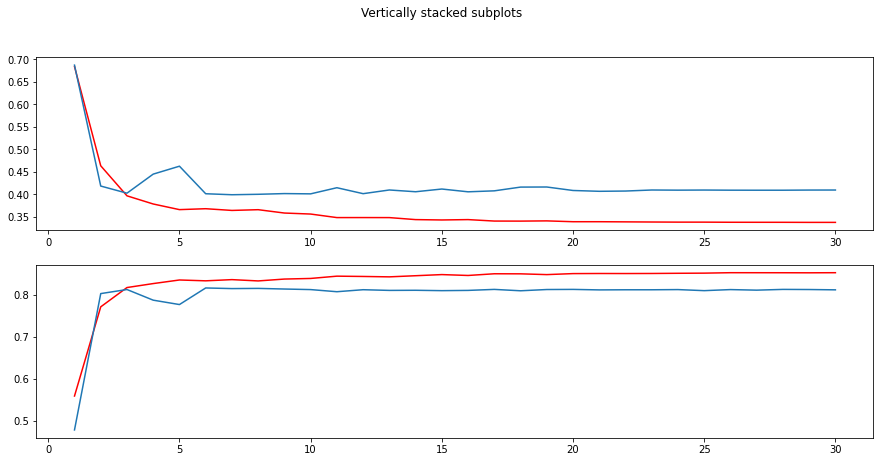

In [13]:
from matplotlib import pyplot as plt
historyDF = pd.DataFrame(history.history)
x = np.arange(1,31)
loss = historyDF['loss']
loss_val = historyDF['val_loss']
acc = historyDF['accuracy']
acc_val = historyDF['val_accuracy']


fig, axs = plt.subplots(2,figsize=(15,7))
fig.suptitle('Vertically stacked subplots')
axs[0].plot(x, loss, 'r', x, loss_val)
axs[1].plot(x, acc, 'r', x, acc_val)

In [14]:
historyDF.info(True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   loss          30 non-null     float64
 1   accuracy      30 non-null     float64
 2   val_loss      30 non-null     float64
 3   val_accuracy  30 non-null     float64
 4   lr            30 non-null     float32
dtypes: float32(1), float64(4)
memory usage: 1.2 KB


In [15]:
# the simple model 
model_s = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        input_dim = vocab_size,
        output_dim = embedding_dim,
        input_length = max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
                               
])
model_s.summary()
model_s.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

history_s = model_s.fit(train_padded,
                      train_labels,
                      epochs=15,
                      validation_data=(test_padded, test_labels))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 16)           16000     
                                                                 
 global_average_pooling1d_2   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_2 (Dense)             (None, 24)                408       
                                                                 
 dense_3 (Dense)             (None, 1)                 25        
                                                                 
Total params: 16,433
Trainable params: 16,433
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
625/625 [==============================] - 4s 6ms/step - loss: 0.6516 - accuracy: 0.6065 - val_loss: 0.54

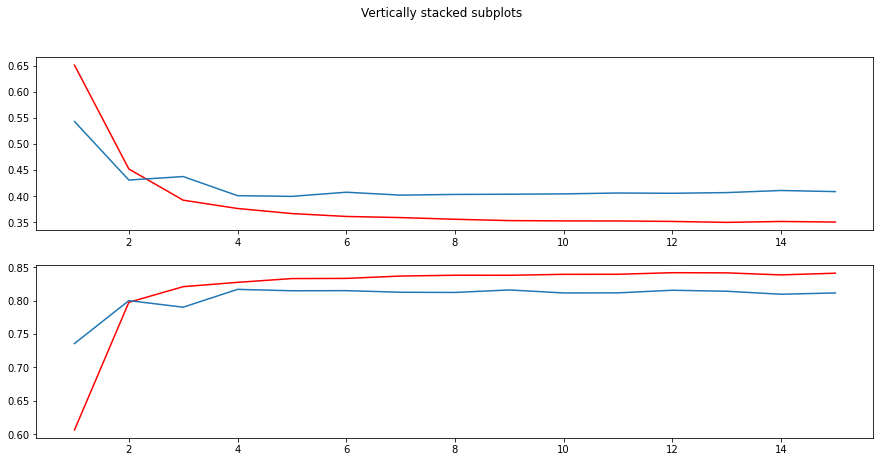

In [16]:
from matplotlib import pyplot as plt
historyDF = pd.DataFrame(history_s.history)
x = np.arange(1,16)
loss = historyDF['loss']
loss_val = historyDF['val_loss']
acc = historyDF['accuracy']
acc_val = historyDF['val_accuracy']


fig, axs = plt.subplots(2,figsize=(15,7))
fig.suptitle('Vertically stacked subplots')
axs[0].plot(x, loss, 'r', x, loss_val)
axs[1].plot(x, acc, 'r', x, acc_val)

model_s.save("mymodel.h5")

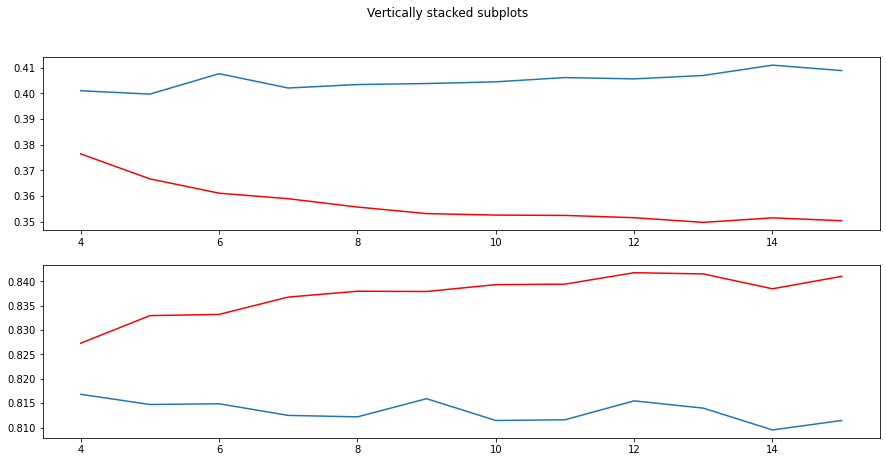

In [19]:
from matplotlib import pyplot as plt
historyDF = pd.DataFrame(history_s.history)
x = np.arange(1,16)
loss = historyDF['loss']
loss_val = historyDF['val_loss']
acc = historyDF['accuracy']
acc_val = historyDF['val_accuracy']

x = x[3:]
loss = loss[3:]
loss_val = loss_val[3:]
acc = acc[3:]
acc_val = acc_val[3:]

fig, axs = plt.subplots(2,figsize=(15,7))
fig.suptitle('Vertically stacked subplots')
axs[0].plot(x, loss, 'r', x, loss_val)
axs[1].plot(x, acc, 'r', x, acc_val)

In [17]:
def solution_model():
    # url = 'https://storage.googleapis.com/download.tensorflow.org/data/sarcasm.json'
    # urllib.request.urlretrieve(url, 'sarcasm.json')

    # DO NOT CHANGE THIS CODE OR THE TESTS MAY NOT WORK
    vocab_size = 1000
    embedding_dim = 16
    max_length = 120
    trunc_type='post'
    padding_type='post'
    oov_tok = "<OOV>"
    training_size = 20000


    sentences = []
    labels = []
    # YOUR CODE HERE

    df = pd.read_json('sarcasm.json')
    df = df.sample(frac=1)
    sentences_ser = df['headline']
    labels_ser = df['is_sarcastic']
    sentences = sentences_ser.tolist()
    labels = labels_ser.tolist()

    # print(type(sentences))
    # print(type(labels))
    # print(type(sentences[0]))
    # print(type(labels[0]))


    train_sentences = sentences[0:training_size]
    train_labels = labels[0:training_size]
    test_sentences = sentences[training_size:]
    test_labels = labels[training_size:]
    # print(len(sentences))
    # print(len(labels))
    # print(len(train_sentences))
    # print(len(train_labels))
    # print(len(test_sentences))
    # print(len(test_labels))

    # model = tf.keras.Sequential([
    # # YOUR CODE HERE. KEEP THIS OUTPUT LAYER INTACT OR TESTS MAY FAIL
    #     tf.keras.layers.Dense(1, activation='sigmoid')
    # ])

    print("Evaluating model...")
    val = model.evaluate(test_sentences, test_labels)
    print(val)

    return model

In [18]:
# Note that you'll need to save your model as a .h5 like this.
# When you press the Submit and Test button, your saved .h5 model will
# be sent to the testing infrastructure for scoring
# and the score will be returned to you.
if __name__ == '__main__':
    model = solution_model()
    #model.save("mymodel.h5")

Evaluating model...


NameError: ignored